In [25]:
import xmltodict as xd, numpy as np, pickle, pandas as pd
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
import skimage.io
import tifffile
import cv2, os
from scipy.ndimage import label as scilabel
from skimage import morphology as morph
from scipy.ndimage.morphology import binary_fill_holes as fill_holes
from skimage.measure import regionprops_table
import torch

def get_img_mask(img,contour_df,bboxes_orig):
    labels=np.zeros(img.shape[:2])
    nuclei=cv2.fillPoly(np.zeros(img.shape[:2]), pts=contour_df['contours_spline'].map(lambda x:x.astype(int)).tolist(), color=1)
    labels[nuclei==1]=2
    labels=labels.astype(int)
    images,lbls=[],[]
    for xmin,xmax,ymin,ymax in bboxes_orig.tolist():
        lbl=labels[xmin:xmax,ymin:ymax].copy()
        im=img[xmin:xmax,ymin:ymax]
        lbl[(fill_small_holes(morph.binary_closing(cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)==255, morph.disk(7)))==True) & (lbl!=2) ]=1
        images.append(im)
        lbls.append(lbl)
    images2=np.stack([cv2.resize(img,(256,256),interpolation=cv2.INTER_CUBIC) for img in images])
    lbls2=np.stack([cv2.resize(lbl,(256,256),interpolation=cv2.INTER_NEAREST) for lbl in lbls])
    X,y=torch.tensor(images2).permute((0,3,1,2)),torch.tensor(lbls2)
    return X,y

def fit_spline(pts):
    try:
        okay = np.where(np.abs(np.diff(pts,axis=0)).sum(1) > 0)[0]
        pts = np.vstack([pts[okay], pts[-1]])
        tck, u = splprep(pts.T, u=None, s=0.0, per=1) 
        u_new = np.linspace(u.min(), u.max(), 1000)
        x_new, y_new = splev(u_new, tck, der=0)
        pts=np.vstack((x_new, y_new)).T
    except:
        pass
    return pts

def fill_small_holes(BW,max_hole_size=35,connectivity=4):
    return morph.remove_small_objects(BW, min_size=max_hole_size, connectivity = connectivity, in_place=False)==False

def read_xml(xml):
    with open(xml,"rb") as f:
        d=xd.parse(f)
    cells=[]
    cell_dot=[]
    for i,annotation in enumerate(d['ASAP_Annotations']["Annotations"]["Annotation"]):
            lbl=annotation["@PartOfGroup"]
            contour=np.array([(float(coord["@X"]),float(coord["@Y"])) for coord in annotation["Coordinates"]["Coordinate"]])
            cells.append(contour)
            
    contour_df=pd.DataFrame(cells,columns=['contours'])
    contour_df['xmin']=contour_df['contours'].map(lambda x: x[:,0].min())
    contour_df['xmax']=contour_df['contours'].map(lambda x: x[:,0].max())
    contour_df['ymin']=contour_df['contours'].map(lambda x: x[:,1].min())
    contour_df['ymax']=contour_df['contours'].map(lambda x: x[:,1].max())
    contour_df['xmean']=contour_df['contours'].map(lambda x: x[:,0].mean())
    contour_df['ymean']=contour_df['contours'].map(lambda x: x[:,1].mean())
    contour_df['contours_spline']=contour_df['contours'].map(fit_spline)
    return contour_df
            
def read_tif(tif):
    return cv2.cvtColor(cv2.imread(tif),cv2.COLOR_BGR2RGB)

def get_bounding_boxes(I):
    BW = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY) > 220
    I[BW]=[255,255,255]
    labels = scilabel(BW)[0]
    plt.figure()
    plt.imshow(labels)
    BW = morph.remove_small_objects(labels, min_size=50, connectivity = 8, in_place=False) # may want to do this compressed then upsample?
    BW2 = morph.remove_small_objects(labels, min_size=500000, connectivity = 8, in_place=False)
    plt.figure()
    plt.imshow(BW)
    plt.figure()
    plt.imshow(BW2)
    BW[BW2!=0]=0
    BW = fill_holes(BW)
    plt.figure()
    plt.imshow(BW)
    I[BW!=1]=[255,255,255]
    labels = scilabel(BW)[0]
    return I,labels#regionprops_table(labels,properties=['bbox'])

def pipeline(basename='aty/1',basedir="images"):
    print(basename)
    img=read_tif(f'{basedir}/{basename}.tif')
    
    contour_df=read_xml(f'{basedir}/{basename}.xml')# nc_annotations
#     nuclei=cv2.fillPoly(np.zeros(img.shape[:2]), pts=contour_df['contours_spline'].map(lambda x:x.astype(int)).tolist(), color=1)

#     img,bboxes=get_bounding_boxes(img)
    celltype=basename.split('/')[-2]
    bboxes=pickle.load(open(f'{basedir}/{celltype}/{celltype}_dict.p','rb'))[os.path.basename(basename).split("_")[0]]
    bboxes=np.array([bboxes[k] for i,k in enumerate(list(bboxes.keys())) if i])*4
    X,y=get_img_mask(img,contour_df,bboxes)
    return X,y,[celltype]*len(X)
#     img=cv2.copyMakeBorder(img, 1, 1, 1, 1, cv2.BORDER_CONTANT, 255)
#     nuclei=cv2.copyMakeBorder(nuclei, 1, 1, 1, 1, cv2.BORDER_CONTANT, 0)
    
#     lbls=np.zeros(img.shape[:2])

#     lbls[fill_small_holes(morph.binary_closing(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)==255, morph.disk(7)))]=1

#     lbls[nuclei==1]=2
            

In [7]:
# ! mkdir new_images2
# ! mv new_images2 images2

In [24]:
import numpy as np, glob
# ! cd new_images2 && tar -xvf *tar*
# ! mv images2/squamous images2/sq
# ! comm -3 <(ls -lah images2/*/* | awk '{print $9}' | awk -F "/" '{print $3}' | sort) <(ls -lah images/*/* | awk '{print $9}' | awk -F "/" '{print $3}' | sort)
np.setdiff1d(np.array([x.replace("images2/","") for x in glob.glob("images2/*/*")]),np.array([x.replace("images/","") for x in glob.glob("images/*/*")]))

array(['aty/10_ASAP.xml', 'aty/11_ASAP.xml', 'aty/12_ASAP.xml',
       'aty/13_ASAP.xml', 'aty/14_ASAP.xml', 'aty/9_ASAP.xml',
       'neg/6_ASAP.xml', 'neg/7_ASAP.xml', 'neg/8_ASAP.xml',
       'neg/9_ASAP.xml', 'sq/6_ASAP.xml', 'sq/7_ASAP.xml'], dtype='<U15')

In [27]:
! mkdir inputs_new

In [28]:
from torch.utils.data import TensorDataset
import glob
from functools import reduce
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
basedir="images2"#images
basenames=[x.replace(".xml","").replace(f"{basedir}/","") for x in glob.glob(f"{basedir}/*/*.xml")]
XY=[pipeline(basename,basedir) for basename in basenames]

X=torch.cat([xy[0] for xy in XY],0)
Y=torch.cat([xy[1] for xy in XY],0)
le=LabelEncoder()
celltype=le.fit_transform(np.hstack([xy[2] for xy in XY]))

idx=np.arange(len(X))
np.random.seed(42)
X_train,X_val,Y_train,Y_val=train_test_split(X.numpy(),Y.numpy(),stratify=celltype,random_state=42)
X_train,X_val=torch.tensor(X_train)/255.,torch.tensor(X_val)/255.
Y_train,Y_val=torch.tensor(Y_train).long(),torch.tensor(Y_val).long()
train_dataset=TensorDataset(X_train,Y_train)
val_dataset=TensorDataset(X_val,Y_val)

torch.save(train_dataset,"inputs_new/train_data.pth") # inputs
torch.save(val_dataset,"inputs_new/val_data.pth") # inputs

aty/13_ASAP


/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][10]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][10]=x[1][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][9]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.p

aty/1_ASAP
aty/8_ASAP
aty/7_ASAP


/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][36]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][36]=x[1][0]
  (i, m, i)))


aty/11_ASAP


/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][31]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][31]=x[1][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][37]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][37]=x[1][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][32]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][32]=x[1][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib

aty/5_ASAP


/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][58]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][58]=x[1][0]
  (i, m, i)))


aty/4_ASAP
aty/2_ASAP


/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][35]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][35]=x[1][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][55]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][55]=x[1][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][39]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][39]=x[1][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib

aty/0_ASAP


/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][38]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][38]=x[1][0]
  (i, m, i)))


aty/9_ASAP


/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][3]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][3]=x[1][0]
  (i, m, i)))


aty/10_ASAP
aty/6_ASAP
aty/3_ASAP
aty/12_ASAP
aty/14_ASAP


/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[0][44]=x[0][0]
  (i, m, i)))
/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:227: RuntimeWarning: Setting x[1][44]=x[1][0]
  (i, m, i)))


sq/1_ASAP
sq/7_ASAP
sq/5_ASAP
sq/4_ASAP
sq/2_ASAP
sq/0_ASAP
sq/6_ASAP
sq/3_ASAP
neg/1_ASAP
neg/8_ASAP
neg/7_ASAP
neg/5_ASAP
neg/4_ASAP
neg/2_ASAP
neg/0_ASAP
neg/9_ASAP
neg/6_ASAP
neg/3_ASAP


In [29]:
! ls -lah inputs*/*

-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 4.6G Oct 26 15:49 inputs/train_data.pth
-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 1.6G Oct 26 15:50 inputs/val_data.pth
-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 6.6G Dec 10 00:26 inputs_new/train_data.pth
-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 2.2G Dec 10 00:26 inputs_new/val_data.pth
-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 1.9G Oct 15 16:51 inputs_old/train_data.pth
-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 627M Oct 15 16:51 inputs_old/val_data.pth


In [30]:
# ! ls images/squamous images/sq
! realpath .
val_dataset=torch.load("inputs/train_data.pth")

/dartfs/rc/lab/V/VaickusL_slow/users/jlevy/autoparis/segmentation_practice


In [13]:
val_dataset.tensors[1].min()

tensor(0)

In [11]:
val_dataset.tensors[0].shape

torch.Size([3690, 3, 256, 256])

In [3]:
X=val_dataset.tensors[0].cuda()

In [4]:
y=val_dataset.tensors[1].cuda()

In [20]:
y.max()

tensor(2, device='cuda:0')

In [5]:
import sys
sys.path.insert(0,os.path.abspath("../PathPretrain"))

In [6]:
from train_model import SegmentationTransform
transform=SegmentationTransform(resize=224,image_size=256,mean=torch.tensor([0.5, 0.5, 0.5]),std=torch.tensor([0.1, 0.1, 0.1]))

nonechucks may not work properly with this version of PyTorch (1.6.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [11]:
transform(X[:10],y[:10])[1].max()

tensor(2, device='cuda:0')

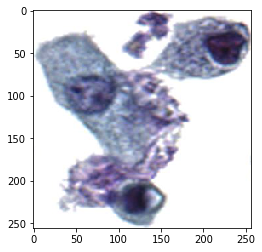

In [15]:
plt.imshow(X[5].permute((1,2,0)).numpy())

In [7]:
# img,boxes=pipeline("aty/0_ASAP") # also use this to populate classification pipeline in addition to segmentation

In [20]:
# regionprops_table(boxes,properties=['bbox'])
# list(enumerate(list(d2['2'].keys())))

In [23]:
from PIL import Image
np.array(Image.open("images/aty/20.png")).shape

(2048, 2048, 3)

In [17]:
import numpy as np


array([[   0,  122,    0,  209],
       [   0,  161,  209,  398],
       [   0,  251,  398,  558],
       [   0,  212,  558,  696],
       [   0,  208,  696,  875],
       [   0,  190,  875, 1047],
       [   0,  180, 1047, 1224],
       [   0,  153, 1224, 1444],
       [   0,  155, 1444, 1631],
       [   0,  164, 1631, 1915],
       [ 271,  442,    0,  180],
       [ 271,  451,  180,  390],
       [ 271,  401,  390,  642],
       [ 271,  440,  642,  847],
       [ 271,  468,  847, 1075],
       [ 271,  410, 1075, 1263],
       [ 271,  415, 1263, 1478],
       [ 271,  428, 1478, 1669],
       [ 271,  486, 1669, 1824],
       [ 271,  460, 1824, 2026],
       [ 506,  677,    0,  178],
       [ 506,  671,  178,  357],
       [ 506,  689,  357,  604],
       [ 506,  745,  604,  756],
       [ 506,  623,  756,  995],
       [ 506,  680,  995, 1195],
       [ 506,  702, 1195, 1408],
       [ 506,  701, 1408, 1569],
       [ 506,  717, 1569, 1775],
       [ 506,  735, 1775, 1971],
       [ 7

In [24]:
! ls images/aty

0.png	     15_ASAP.tif  21_ASAP.tif  29.png	    35.png	 5.png
0_ASAP.tif   16.png	  22.png       29_ASAP.tif  35_ASAP.tif  5_ASAP.tif
0_ASAP.xml   16_ASAP.tif  22_ASAP.tif  2_ASAP.tif   36.png	 5_ASAP.xml
1.png	     17.png	  23.png       2_ASAP.xml   36_ASAP.tif  6.png
10.png	     17_ASAP.tif  23_ASAP.tif  3.png	    37.png	 6_ASAP.tif
10_ASAP.tif  18.png	  24.png       30.png	    37_ASAP.tif  6_ASAP.xml
11.png	     18_ASAP.tif  24_ASAP.tif  30_ASAP.tif  38.png	 7.png
11_ASAP.tif  19.png	  25.png       31.png	    38_ASAP.tif  7_ASAP.tif
12.png	     19_ASAP.tif  25_ASAP.tif  31_ASAP.tif  39.png	 7_ASAP.xml
12_ASAP.tif  1_ASAP.tif   26.png       32.png	    39_ASAP.tif  8_ASAP.tif
13.png	     1_ASAP.xml   26_ASAP.tif  32_ASAP.tif  3_ASAP.tif	 8_ASAP.xml
13_ASAP.tif  2.png	  27.png       33.png	    3_ASAP.xml	 9.png
14.png	     20.png	  27_ASAP.tif  33_ASAP.tif  4.png	 9_ASAP.tif
14_ASAP.tif  20_ASAP.tif  28.png       34.png	    4_ASAP.tif	 Thumbs.db
15.png	     21.png	  28_ASAP.tif  34_ASA

In [35]:
# ! pip install segmentation_models_pytorch
# ! pwd

/dartfs/rc/lab/V/VaickusL_slow/users/jlevy/autoparis/segmentation_practice


In [42]:
import xmltodict as xd, numpy as np, pickle, pandas as pd


In [43]:
# d['ASAP_Annotations']['Annotations']['Annotation'][0]['Coordinates']['Coordinate']#.keys()

In [45]:
with open('images/aty/2_ASAP.xml',"rb") as f:
    d=xd.parse(f)
cells=[]
cell_dot=[]
for i,annotation in enumerate(d['ASAP_Annotations']["Annotations"]["Annotation"]):
#     if annotation["@Type"]=="Dot":
#         cell_dot.append(np.array((float(annotation["Coordinates"]["Coordinate"]["@X"]),float(annotation["Coordinates"]["Coordinate"]["@Y"]))))
#     elif annotation["@Type"]=="Spline":
#         try:
        lbl=annotation["@PartOfGroup"]
#         print(lbl)
        contour=np.array([(float(coord["@X"]),float(coord["@Y"])) for coord in annotation["Coordinates"]["Coordinate"]])
        cells.append(contour)
#         except:
#             print(i)

In [46]:
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt

# define pts from the question
def fit_spline(pts):
    try:
        okay = np.where(np.abs(np.diff(pts,axis=0)).sum(1) > 0)[0]
        pts = np.vstack([pts[okay], pts[-1]])#, pts[0]
#     print(pts)
#     print(pts)
#     yp = np.r_[yp[okay], yp[-1], yp[0]]

        tck, u = splprep(pts.T, u=None, s=0.0, per=1) 
        u_new = np.linspace(u.min(), u.max(), 1000)
        x_new, y_new = splev(u_new, tck, der=0)
        pts=np.vstack((x_new, y_new)).T
    except:
        pass

#     plt.plot(pts[:,0], pts[:,1], 'ro')
#     plt.plot(x_new, y_new, 'b--')
    return pts

In [47]:
contour_df=pd.DataFrame(cells,columns=['contours'])
contour_df['xmin']=contour_df['contours'].map(lambda x: x[:,0].min())
contour_df['xmax']=contour_df['contours'].map(lambda x: x[:,0].max())
contour_df['ymin']=contour_df['contours'].map(lambda x: x[:,1].min())
contour_df['ymax']=contour_df['contours'].map(lambda x: x[:,1].max())
contour_df['xmean']=contour_df['contours'].map(lambda x: x[:,0].mean())
contour_df['ymean']=contour_df['contours'].map(lambda x: x[:,1].mean())
contour_df['contours_spline']=contour_df['contours'].map(fit_spline)

/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][27]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][27]=x[1][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][26]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][26]=x[1][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][25]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][25]=x[1][0]
  (i, m, i)))
/home/anaconda3/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][35]=x[0][0]
  (i, m, i)))
/home/anaconda3/lib/python3

In [3]:
import pickle
d2=pickle.load(open('images/aty/aty_dict.p','rb')) # don't have this for the new images


In [5]:
d2.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39'])

In [52]:
from sklearn.metrics import pairwise_distances


d2=pickle.load(open('images/aty/aty_dict_deident.p','rb')) # don't have this for the new images

bboxes={k:np.array(v)*4 for k,v in d2["2"].items()}
bboxes_orig=np.vstack([bboxes[i] for i in bboxes])
bboxes=np.vstack([(bboxes[i][:2].mean(),bboxes[i][2:].mean()) for i in bboxes])

# def point_in(xy,X):
# #     print()
#     x,y=xy
#     xmin,xmax,ymin,ymax=X
#     return all([x>=xmin,x<=xmax,y>=ymin,y<=ymax])

# def reject_get_nearest(membership,xy,bboxes):
#     if not membership:
#         return pairwise_distances(xy.reshape(1,-1),bboxes).argmax(1)[0]
#     else:
#         return membership[0]

# contour_df['bbox_membership']=contour_df[['xmean','ymean']].apply(lambda xy: reject_get_nearest(np.where([point_in(xy.values,bboxes_orig[i]) for i in range(bboxes.shape[0])])[0].tolist(),xy.values,bboxes),axis=1)#pairwise_distances(contour_df[['xmean','ymean']],bboxes).argmin(1)

In [53]:
# bboxes
# contour_df['bbox_membership'].value_counts() # I say just draw the polygons and save the hassle

In [54]:
# contour_df['bbox_membership']

In [55]:
# contour_df

In [56]:
import skimage.io
import tifffile
import cv2
img=cv2.cvtColor(cv2.imread("images/aty/2_ASAP.tif"),cv2.COLOR_BGR2RGB)

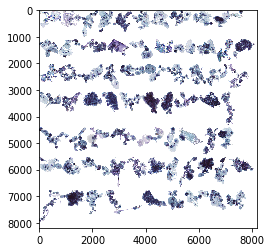

In [57]:
plt.imshow(img)

In [58]:
# contour_df['contours_spline'].tolist()

In [59]:
# contours_spline
nuclei=cv2.fillPoly(np.zeros(img.shape[:2]), pts=contour_df['contours_spline'].map(lambda x:x.astype(int)).tolist(), color=1)


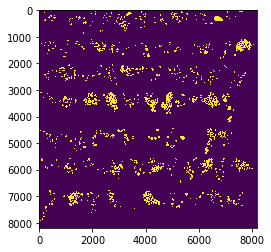

In [132]:
plt.imshow(nuclei)

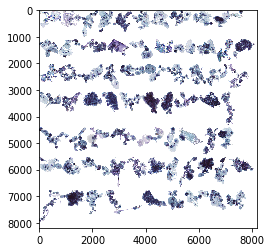

In [60]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [61]:
from skimage import morphology as morph
from scipy.ndimage.morphology import binary_fill_holes as fill_holes

def fill_small_holes(BW,max_hole_size=35,connectivity=4):
    return morph.remove_small_objects(BW, min_size=max_hole_size, connectivity = connectivity, in_place=True)==False

lbls=np.zeros(img.shape[:2])

lbls[fill_small_holes(morph.binary_closing(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)==255, morph.disk(7)))]=1

lbls[nuclei==1]=2


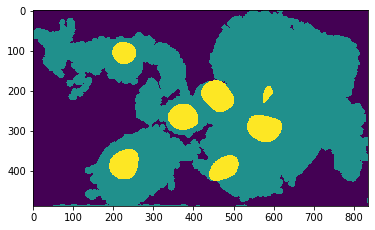

In [62]:
xmin,xmax,ymin,ymax=bboxes_orig[0]
plt.imshow(lbls[xmin:xmax,ymin:ymax])


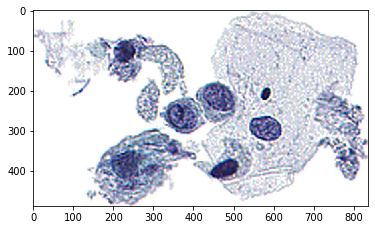

In [63]:
plt.imshow(img[xmin:xmax,ymin:ymax])

In [81]:
! pip install centrosome

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 777 kB 929 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Using cached numpy-1.19.2-cp37-cp37m-manylinux2010_x86_64.whl (14.5 MB)
  Using cached scikit_image-0.17.2-cp37-cp37m-manylinux1_x86_64.whl (12.5 MB)
     |████████████████████████████████| 2.2 MB 4.6 MB/s eta 0:00:01
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Using cached scipy-1.5.3-cp37-cp37m-manylinux1_x86_64.whl (25.9 MB)
  Created wheel for centrosome: filename=centrosome-1.2.0-cp37-cp37m-linux_x86_64.whl size=1209970 sha256=752173941bb0a403f99d67ff945fe437609d3d1200ce59f275d53dc8982e7de9
  Stored in directory: /dartfs-hpc/rc/home/w/f003k8w/.cache/pip/wheels/39/f0/f6/f8e0fceafbf1def0a390b7743cd49196dd513fc5237e09e14d
Successfully built

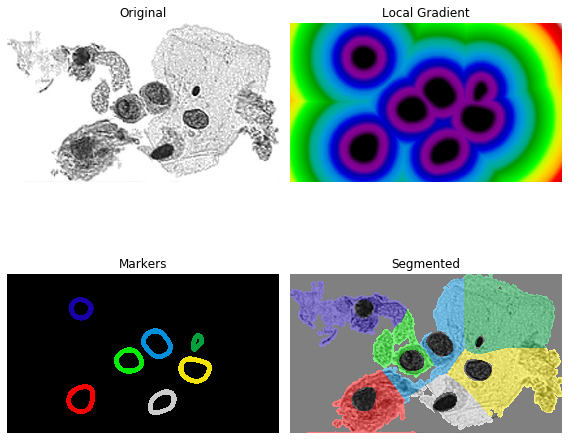

In [82]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

image = img_as_ubyte(cv2.cvtColor(img[xmin:xmax,ymin:ymax],cv2.COLOR_RGB2GRAY))

# denoise image
denoised = lbls[xmin:xmax,ymin:ymax]!=2#rank.median(image, disk(2))

# find continuous region (low gradient -
# where less than 10 for this image) --> markers
# disk(5) is used here to get a more smooth image
markers = rank.gradient(denoised, disk(8)) > 25
markers = ndi.label(markers)[0]

# local gradient (disk(2) is used to keep edges thin)
gradient = ndi.distance_transform_edt(lbls[xmin:xmax,ymin:ymax]!=2)#rank.gradient(lbls[xmin:xmax,ymin:ymax]==2,disk(10))#rank.gradient(denoised, disk(2))

# process the watershed
labels = watershed(gradient, markers,mask=lbls[xmin:xmax,ymin:ymax]==1)

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Original")

ax[1].imshow(gradient, cmap=plt.cm.nipy_spectral)
ax[1].set_title("Local Gradient")

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title("Markers")

ax[3].imshow(image, cmap=plt.cm.gray)
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral, alpha=.5)
ax[3].set_title("Segmented")

for a in ax:
    a.axis('off')

fig.tight_layout()

In [98]:
image = np.zeros((10, 10))
labels = np.zeros((10, 10), int)
mask = np.ones((10, 10), bool)
labels[0, 5] = 1
labels[9, 5] = 2
result, distances = propagate(image, labels, mask, 1.0)

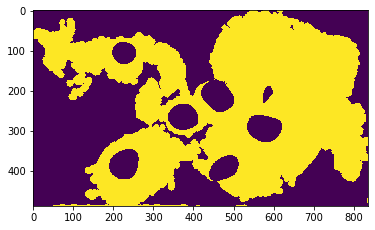

In [101]:
plt.imshow(lbls[xmin:xmax,ymin:ymax]==1)

Text(0.5, 1.0, 'Segmented')

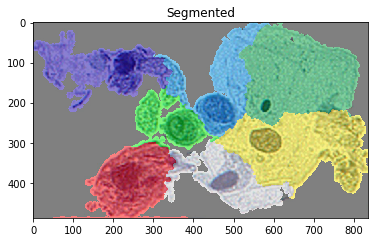

In [108]:
from centrosome.propagate import propagate
res=propagate(cv2.cvtColor(img[xmin:xmax,ymin:ymax],cv2.COLOR_RGB2GRAY), scilabel(lbls[xmin:xmax,ymin:ymax]==2)[0], lbls[xmin:xmax,ymin:ymax]>=1, 1.0)[0]
plt.imshow(img[xmin:xmax,ymin:ymax], cmap=plt.cm.gray)
plt.imshow(res, cmap=plt.cm.nipy_spectral, alpha=.5)
plt.title("Segmented")



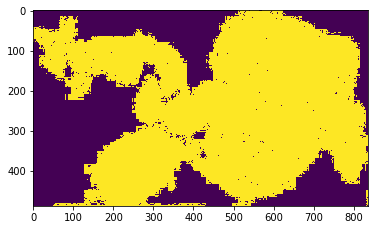

In [53]:
lbls=np.zeros(img.shape[:2])
lbls[cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)!=255]=1
xmin,xmax,ymin,ymax=bboxes_orig[0]
plt.imshow(lbls[xmin:xmax,ymin:ymax])

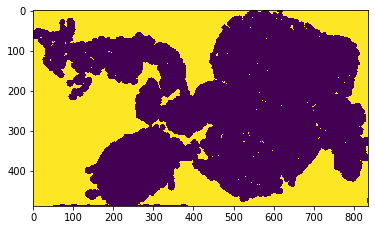

In [25]:
xmin,xmax,ymin,ymax=bboxes_orig[0]
plt.imshow(lbls[xmin:xmax,ymin:ymax])

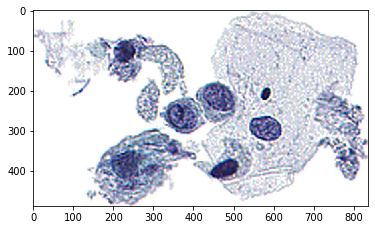

In [13]:
plt.imshow(img[xmin:xmax,ymin:ymax])

In [200]:
import torch

def get_img_mask(img,xml,bbox_dict):
    print(xml)
    with open(xml,"rb") as f:
        d=xd.parse(f)
    cells=[]
    cell_dot=[]
    for i,annotation in enumerate(d['ASAP_Annotations']["Annotations"]["Annotation"]):
            lbl=annotation["@PartOfGroup"]
            contour=np.array([(float(coord["@X"]),float(coord["@Y"])) for coord in annotation["Coordinates"]["Coordinate"]])
            cells.append(contour)
            
    contour_df=pd.DataFrame(cells,columns=['contours'])
    contour_df['xmin']=contour_df['contours'].map(lambda x: x[:,0].min())
    contour_df['xmax']=contour_df['contours'].map(lambda x: x[:,0].max())
    contour_df['ymin']=contour_df['contours'].map(lambda x: x[:,1].min())
    contour_df['ymax']=contour_df['contours'].map(lambda x: x[:,1].max())
    contour_df['xmean']=contour_df['contours'].map(lambda x: x[:,0].mean())
    contour_df['ymean']=contour_df['contours'].map(lambda x: x[:,1].mean())
    contour_df['contours_spline']=contour_df['contours'].map(fit_spline)
    
    img=cv2.cvtColor(cv2.imread(img),cv2.COLOR_BGR2RGB)
    
    labels=np.zeros(img.shape[:2])

    
    nuclei=cv2.fillPoly(np.zeros(img.shape[:2]), pts=contour_df['contours_spline'].map(lambda x:x.astype(int)).tolist(), color=1)

    labels[nuclei==1]=2
    
    labels=labels.astype(int)
    
#     print(np.unique(labels.flatten()))
    
    d2=pickle.load(open(bbox_dict,'rb'))

    bboxes={k:np.array(v)*4 for k,v in d2["2"].items()}
    
    bboxes_orig=np.vstack([bboxes[i] for i in bboxes])
    images,lbls=[],[]
    for xmin,xmax,ymin,ymax in bboxes_orig.tolist():
        lbl=labels[xmin:xmax,ymin:ymax].copy()
        im=img[xmin:xmax,ymin:ymax]
        lbl[(fill_small_holes(morph.binary_closing(cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)==255, morph.disk(7)))==True) & (lbl!=2) ]=1
        
        images.append(im)
        lbls.append(lbl)
    images2=np.stack([cv2.resize(img,(256,256),interpolation=cv2.INTER_CUBIC) for img in images])
    lbls2=np.stack([cv2.resize(lbl,(256,256),interpolation=cv2.INTER_NEAREST) for lbl in lbls])
    X,y=torch.tensor(images2).permute((0,3,1,2)),torch.tensor(lbls2)
    return X,y
        
        
    
    
    
    

In [194]:
# X,y=get_img_mask("neg/2_ASAP.tif","neg/2_ASAP.xml",'neg/neg_dict_deident.p')

In [201]:
# glob.glob("*/*.p")

aty/1_ASAP.xml
aty/2_ASAP.xml
aty/0_ASAP.xml
aty/3_ASAP.xml
sq/1_ASAP.xml
sq/2_ASAP.xml
sq/0_ASAP.xml
sq/3_ASAP.xml
neg/1_ASAP.xml
neg/2_ASAP.xml
neg/0_ASAP.xml
neg/3_ASAP.xml


In [202]:
from torch.utils.data import TensorDataset
import glob
from sklearn.model_selection import train_test_split
XY=[get_img_mask(f.replace("xml","tif"),f,"{0}/{0}_dict_deident.p".format(f.split("/")[0])) for f in glob.glob("*/*.xml")]

X=torch.cat([xy[0] for xy in XY],0)
Y=torch.cat([xy[1] for xy in XY],0)


idx=np.arange(len(X))
np.random.seed(42)
X_train,X_val,Y_train,Y_val=train_test_split(X.numpy(),Y.numpy(),random_state=42)
X_train,X_val=torch.tensor(X_train)/255.,torch.tensor(X_val)/255.
Y_train,Y_val=torch.tensor(Y_train).long(),torch.tensor(Y_val).long()
train_dataset=TensorDataset(X_train,Y_train)
val_dataset=TensorDataset(X_val,Y_val)

torch.save(train_dataset,"inputs/train_data.pth")
torch.save(val_dataset,"inputs/val_data.pth")

In [207]:
Y.shape

torch.Size([2004, 256, 256])

In [204]:
! mkdir inputs

In [179]:
#.shape

torch.Size([200, 3, 256, 256])

In [180]:
#.shape

torch.Size([200, 256, 256])

In [177]:
lbls2.shape

(200, 256, 256)

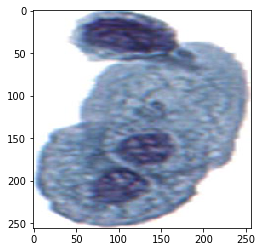

In [171]:
plt.imshow(cv2.resize(images[3],(256,256),interpolation=cv2.INTER_CUBIC))

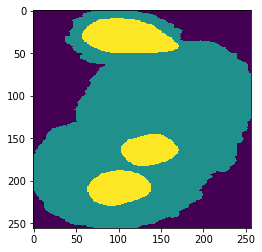

In [172]:
plt.imshow(cv2.resize(lbls[3],(256,256),interpolation=cv2.INTER_NEAREST))

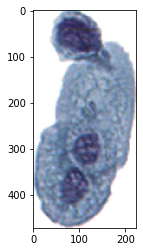

In [168]:
plt.imshow(images[3])

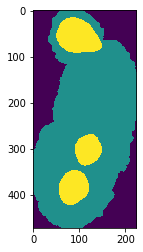

In [164]:
plt.imshow(lbls[3])

In [ ]:
plt.imshow(img[xmin:xmax,ymin:ymax])

In [40]:
bboxes[1]

array([  0, 488,   0, 836])

In [38]:
bboxes["0"]

KeyError: '0'